In [1]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load(
  tidyverse, 
  tidymodels,  # The modern standard for ML in R
  vip,         # For variable importance plots
  randomForest,
  here
)

# Load Master Data
master_data <- read_csv("../data/master_data_final.csv", show_col_types = FALSE)

# 1. Prepare the data
# We remove IDs (iso3c, country) but keep numeric predictors
model_data <- master_data %>%
  select(hdi, gdp_per_capita, life_expectancy_wb, unemployment_rate, 
         education_expenditure, health_expenditure) %>%
  drop_na()

# 2. Split the data (80% Training, 20% Testing)
set.seed(123) # Ensures we get the same split every time
data_split <- initial_split(model_data, prop = 0.80)
train_data <- training(data_split)
test_data  <- testing(data_split)

print(paste("Training Samples:", nrow(train_data)))
print(paste("Testing Samples:", nrow(test_data)))

Loading required package: pacman



[1] "Training Samples: 3102"
[1] "Testing Samples: 776"


In [2]:
# 1. Define the Linear Regression Model
lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")

# 2. Fit the model to Training Data
lm_fit <- lm_spec %>%
  fit(hdi ~ ., data = train_data) # Predict 'hdi' using everything else (.)

# 3. View the detailed statistical results
print("--- Linear Regression Results ---")
tidy(lm_fit) %>%
  mutate(p.value = scales::pvalue(p.value)) # Format p-values nicely

[1] "--- Linear Regression Results ---"


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),-3.605254e-01,1.031839e-02,-34.940082,<0.001
gdp_per_capita,1.863138e-06,7.836418e-08,23.775383,<0.001
life_expectancy_wb,1.405996e-02,1.568057e-04,89.664829,<0.001
unemployment_rate,2.166917e-03,1.844140e-04,11.750284,<0.001
education_expenditure,4.191261e-03,6.286614e-04,6.666961,<0.001
health_expenditure,1.868681e-03,4.607969e-04,4.055324,<0.001


In [3]:
# 1. Define the Random Forest Model
rf_spec <- rand_forest(trees = 500, mode = "regression") %>%
  set_engine("randomForest", importance = TRUE)

# 2. Fit the model
rf_fit <- rf_spec %>%
  fit(hdi ~ ., data = train_data)

print("--- Random Forest Model Trained ---")
print(rf_fit)

[1] "--- Random Forest Model Trained ---"
parsnip model object


Call:
 randomForest(x = maybe_data_frame(x), y = y, ntree = ~500, importance = ~TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 1

          Mean of squared residuals: 0.0007017643
                    % Var explained: 97.37


In [4]:
# 1. Make Predictions on the Test Set
results <- test_data %>%
  bind_cols(predict(lm_fit, new_data = test_data) %>% rename(pred_lm = .pred)) %>%
  bind_cols(predict(rf_fit, new_data = test_data) %>% rename(pred_rf = .pred))

# 2. Calculate Metrics
metrics_lm <- results %>% metrics(truth = hdi, estimate = pred_lm) %>% mutate(model = "Linear Regression")
metrics_rf <- results %>% metrics(truth = hdi, estimate = pred_rf) %>% mutate(model = "Random Forest")

# 3. Combine and Show
final_metrics <- bind_rows(metrics_lm, metrics_rf) %>%
  filter(.metric == "rmse") %>%
  arrange(.estimate)

print("--- Model Comparison (RMSE: Lower is Better) ---")
print(final_metrics)

[1] "--- Model Comparison (RMSE: Lower is Better) ---"
# A tibble: 2 × 4
  .metric .estimator .estimate model            
  <chr>   <chr>          <dbl> <chr>            
1 rmse    standard      0.0260 Random Forest    
2 rmse    standard      0.0563 Linear Regression


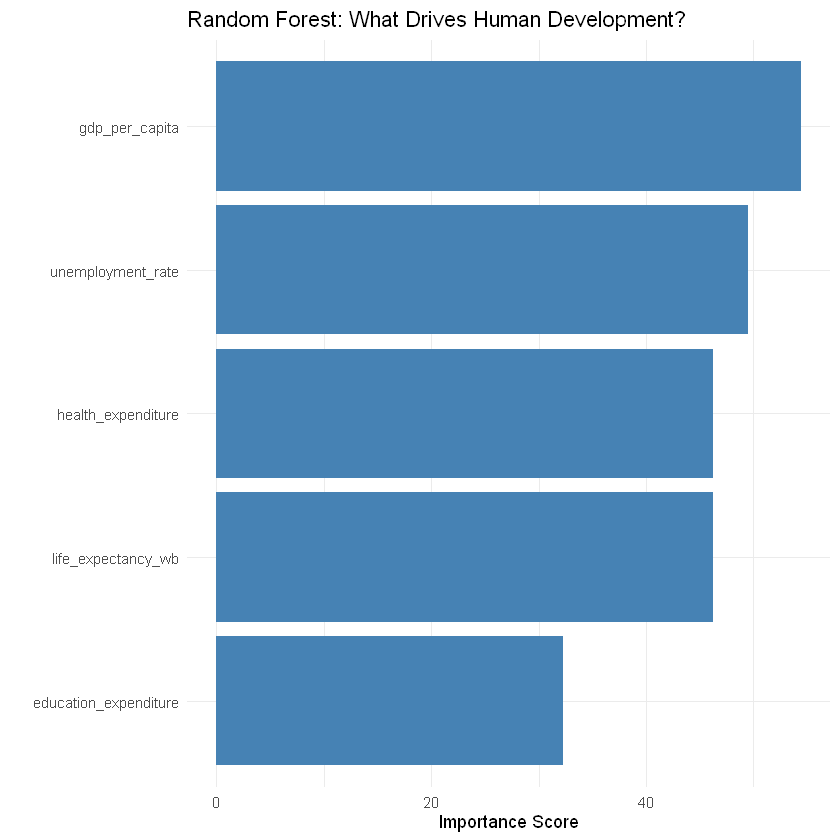

In [5]:
# Visualize Variable Importance from Random Forest
rf_fit %>%
  extract_fit_engine() %>%
  vip(geom = "col", aesthetics = list(fill = "steelblue")) +
  labs(title = "Random Forest: What Drives Human Development?",
       y = "Importance Score") +
  theme_minimal()